# Get 6C Data for Event

In [97]:
import os
import obspy as obs
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client

from andbro__read_sds import __read_sds

In [98]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [124]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"romy_events/figures/"

config['path_to_outdata'] = data_path+"romy_events/data/"

config['path_to_sds'] = archive_path+"romy_archive/"

config['path_to_inventory'] = root_path+"Documents/ROMY/dataless_ringlaser/"

## BSPF coordinates
config['ROMY_lon'] = 11.275501
config['ROMY_lat'] = 48.162941

config['submask'] = ""


## Eventtime
config['eventtime'] = obs.UTCDateTime("2023-09-08 22:10:00")

config['event_name'] = "Marocco"

## Event M42
config['tbeg'] = obs.UTCDateTime("2023-09-08 22:10:00")
config['tend'] = obs.UTCDateTime("2023-09-08 23:00:00")

config['fmin'] = 0.1
config['fmax'] = 10

## Load Data

#### Find event in catalog

In [125]:
event = Client("IRIS").get_events(starttime=config['tbeg'], endtime=config['tend'], minmagnitude=6.0)
event = event[0]

#### Load inventory

In [126]:
romy_inv = obs.read_inventory(config['path_to_inventory']+"dataless.seed.BW_ROMY")
seis_inv = obs.read_inventory(config['path_to_inventory']+"dataless.seed.BW_DROMY")

In [127]:
st0 = obs.Stream()

st0 += __read_sds(config['path_to_sds'], "BW.ROMY.10.BJZ", config['tbeg']-1, config['tend']+1)
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJU", config['tbeg']-1, config['tend']+1)
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJV", config['tbeg']-1, config['tend']+1)

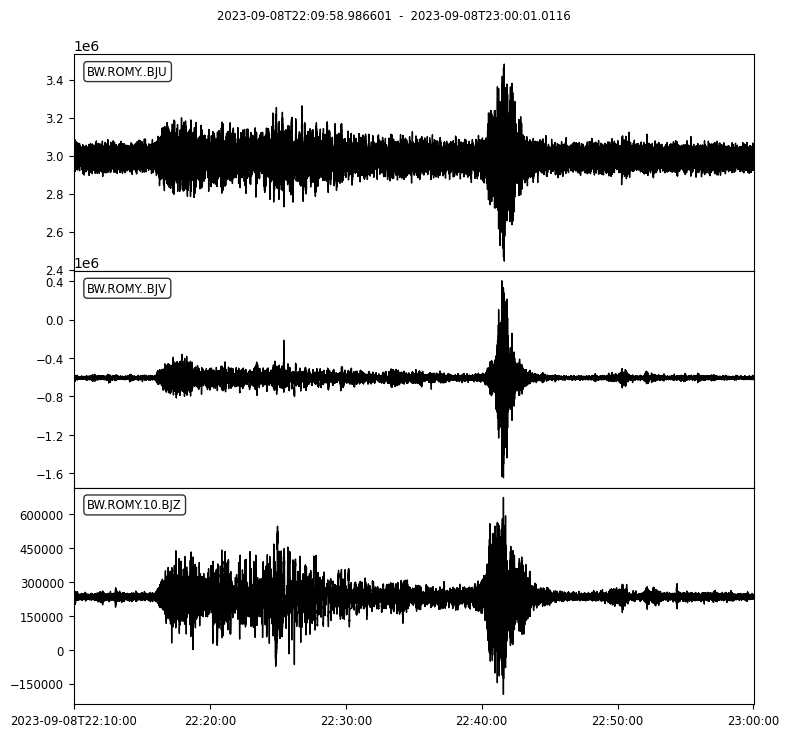

In [128]:
st0.plot(equal_scale=False);

In [129]:
acc = __read_sds(config['path_to_sds'], "BW.DROMY..HH*", config['tbeg']-1, config['tend']+1)

acc.remove_response(seis_inv, output="ACC")

acc.resample(20)

acc.detrend("demean")

3 Trace(s) in Stream:
BW.DROMY..HHE | 2023-09-08T22:09:59.000000Z - 2023-09-08T23:00:01.000000Z | 200.0 Hz, 600401 samples
BW.DROMY..HHN | 2023-09-08T22:09:59.000000Z - 2023-09-08T23:00:01.000000Z | 200.0 Hz, 600401 samples
BW.DROMY..HHZ | 2023-09-08T22:09:59.000000Z - 2023-09-08T23:00:01.000000Z | 200.0 Hz, 600401 samples

3 Trace(s) in Stream:
BW.DROMY..HHE | 2023-09-08T22:09:59.000000Z - 2023-09-08T23:00:00.950000Z | 20.0 Hz, 60040 samples
BW.DROMY..HHN | 2023-09-08T22:09:59.000000Z - 2023-09-08T23:00:00.950000Z | 20.0 Hz, 60040 samples
BW.DROMY..HHZ | 2023-09-08T22:09:59.000000Z - 2023-09-08T23:00:00.950000Z | 20.0 Hz, 60040 samples

3 Trace(s) in Stream:
BW.DROMY..HHE | 2023-09-08T22:09:59.000000Z - 2023-09-08T23:00:00.950000Z | 20.0 Hz, 60040 samples
BW.DROMY..HHN | 2023-09-08T22:09:59.000000Z - 2023-09-08T23:00:00.950000Z | 20.0 Hz, 60040 samples
BW.DROMY..HHZ | 2023-09-08T22:09:59.000000Z - 2023-09-08T23:00:00.950000Z | 20.0 Hz, 60040 samples

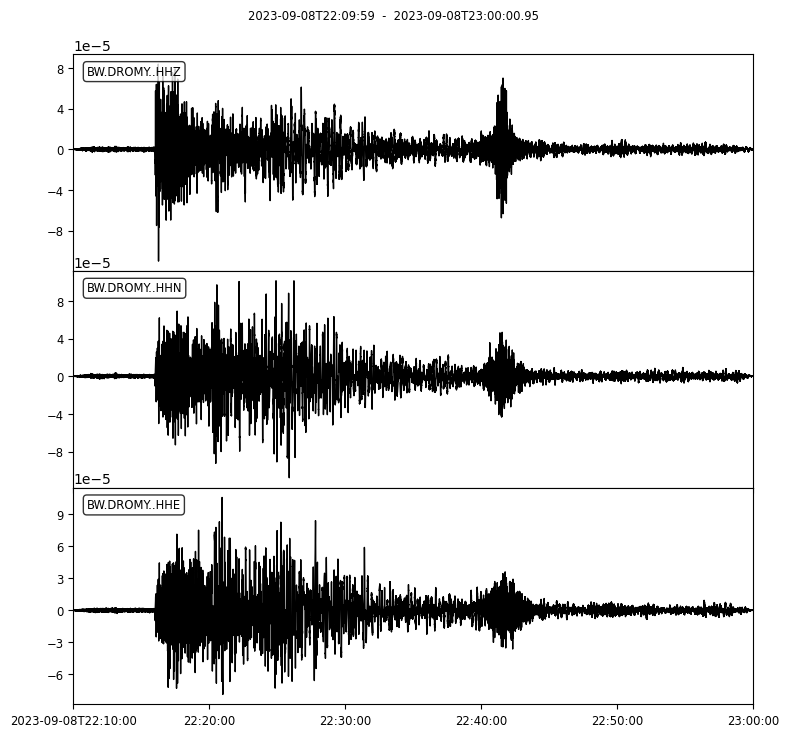

In [130]:
acc.plot(equal_scale=False);

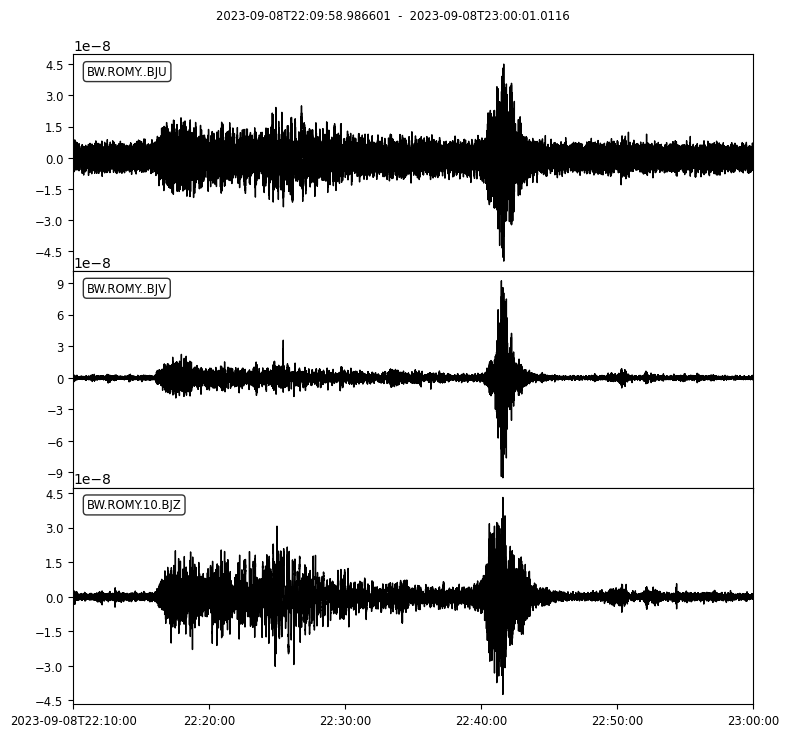

In [131]:
st = st0.copy()

st.remove_sensitivity(romy_inv)

st.detrend("demean")
# st.taper(0.1)
# st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

st.plot(equal_scale=False);

In [132]:
# st = st.rotate(method="->ZNE", inventory=romy_inv)

ori_z = romy_inv.get_orientation("BW.ROMY.10.BJZ")
ori_u = romy_inv.get_orientation("BW.ROMY..BJU")
ori_v = romy_inv.get_orientation("BW.ROMY..BJV")

romy_z = st.select(channel="*Z")[0].data
romy_u = st.select(channel="*U")[0].data
romy_v = st.select(channel="*V")[0].data

from obspy.signal.rotate import rotate2zne

romy_z, romy_n, romy_e =rotate2zne(
                                   romy_z, ori_z['azimuth'], ori_z['dip'],
                                   romy_u, ori_u['azimuth'], ori_u['dip'],
                                   romy_v, ori_v['azimuth'], ori_v['dip'],
                                   inverse=False
                                  )

st_new = st.copy()

st_new.select(channel="*Z")[0].data = romy_z
st_new.select(channel="*U")[0].data = romy_n
st_new.select(channel="*V")[0].data = romy_e

st_new.select(channel="*U")[0].stats.channel = "BJN"
st_new.select(channel="*V")[0].stats.channel = "BJE"


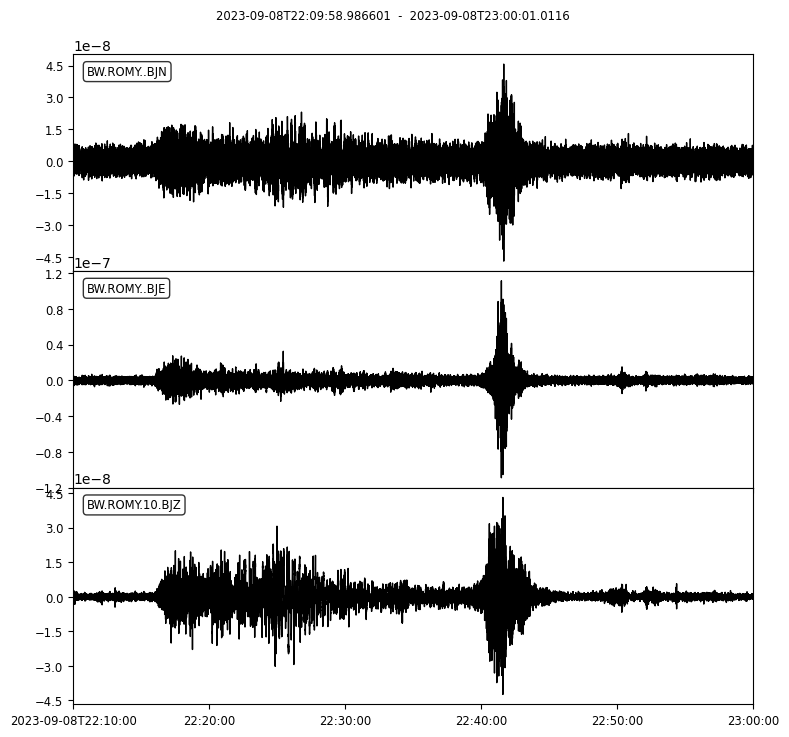

In [133]:
st_new.plot(equal_scale=False);

## Compare Waveforms

In [134]:
def __makeplot_waveform_comparison(st1, st2):

    fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

    font = 14

    ax[0].plot(st1.select(channel="*Z")[0].times(), st1.select(channel="*Z")[0].data, label="Z")
    ax[0].plot(st2.select(channel="*Z")[0].times(), st2.select(channel="*Z")[0].data, label="Z")

    ax[1].plot(st1.select(channel="*U")[0].times(), st1.select(channel="*U")[0].data, label="U")
    ax[1].plot(st2.select(channel="*N")[0].times(), st2.select(channel="*N")[0].data, label="N")

    ax[2].plot(st1.select(channel="*V")[0].times(), st1.select(channel="*V")[0].data, label="V")
    ax[2].plot(st2.select(channel="*E")[0].times(), st2.select(channel="*E")[0].data, label="E")


    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        # ax[i].set_xscale("log")
        ax[i].set_ylabel("rot. rate (rad/s)")

    ax[2].set_xlabel("Frequency (Hz)")
    ax[0].set_title(f"{config['tbeg'].date} | {config['fmin']}-{config['fmax']} Hz ")

    plt.show();
    return fig

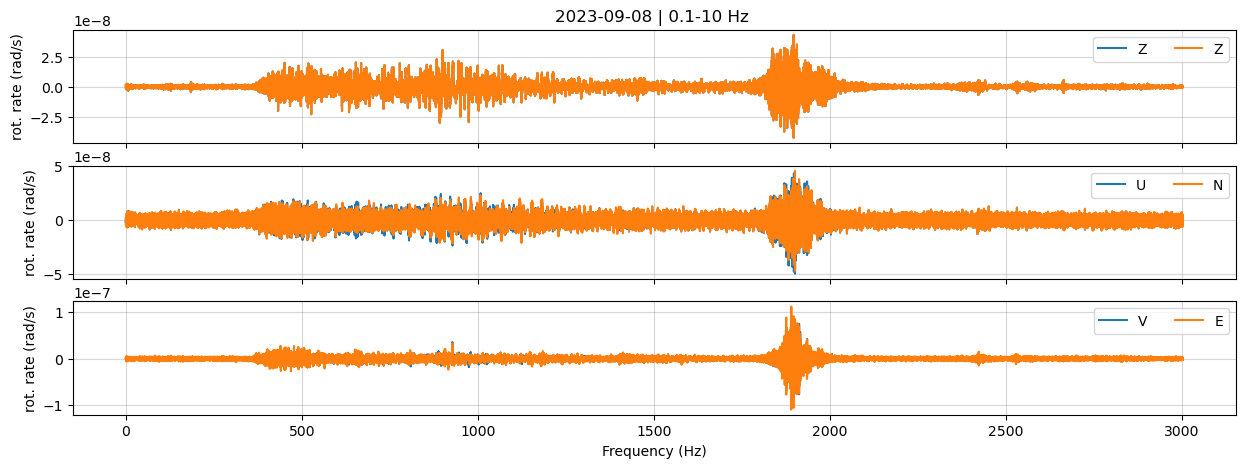

In [135]:
fig = __makeplot_waveform_comparison(st, st_new)

fig.savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_waveforms.png", format="png", dpi=200, bbox_inches='tight');

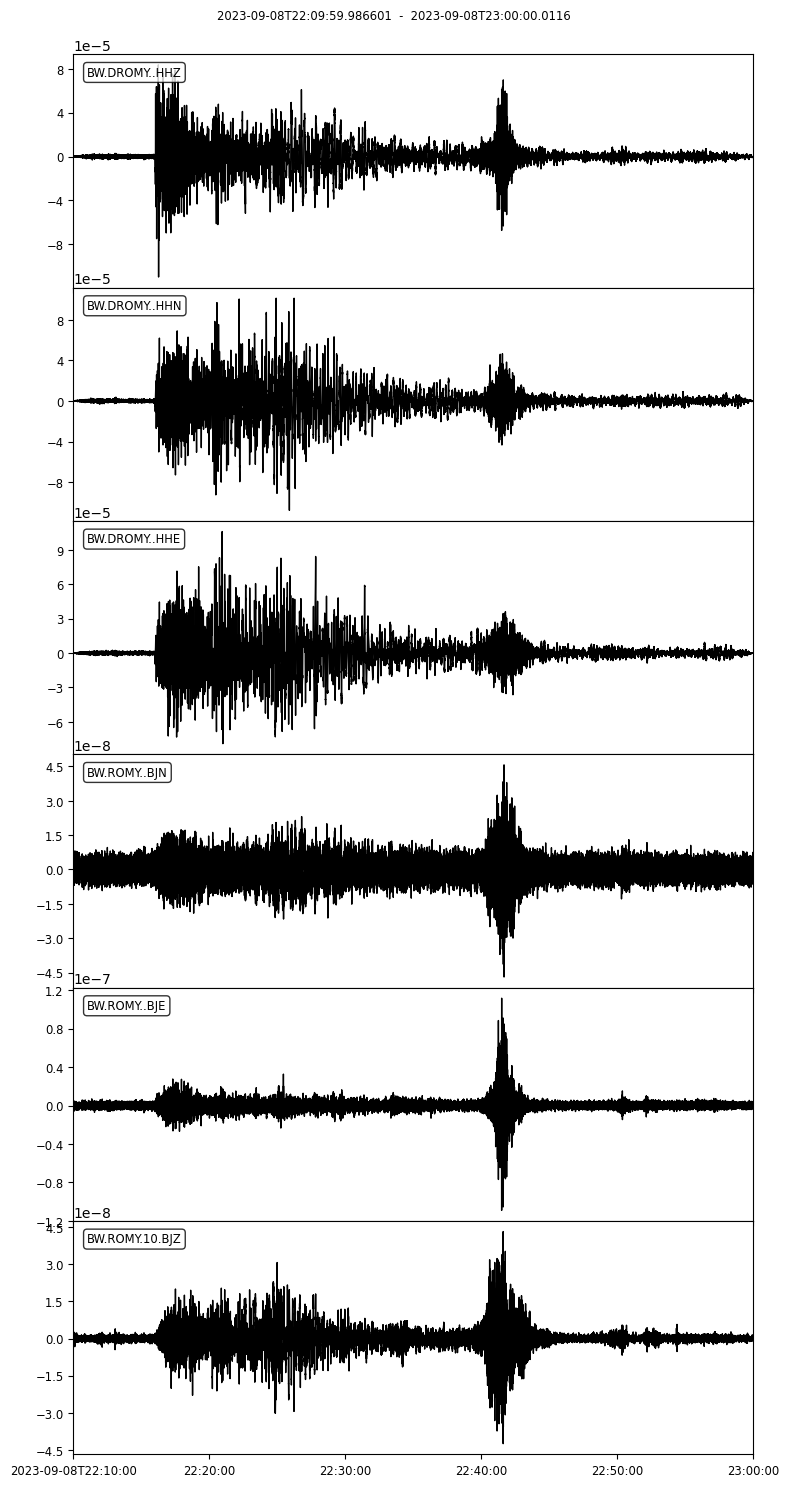

/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [136]:
st_all = st_new.copy();
st_all += acc.copy();

st_all.trim(config['tbeg'], config['tend'])

st_all.plot(equal_scale=False);

st_all.write(config['path_to_outdata']+f"ROMY_{config['event_name']}_{str(config['tbeg'].date).replace('-','')}_6C.mseed", format="MSEED");